# Dynamic optimization of walking on uneven terrain

A simple walking model is optimized to walk over uneven terrain. The
objective is to minimize energy expenditure, quantified by the push-off
work performed with each step. The optimization here seeks to traverse a
stretch of terrain, starting and ending at level walking, and taking the
same amount of time as level walking.

## Walk over a single upward step

The optimal compensation for a single upward step is to speed up
beforehand, lose speed stepping upward, and then speed up again
afterward. The optimal speed-ups both occur over several steps but have
different shapes: the first one increases nearly exponentially with
time, and the second one resembles a saturating exponential. The
optimization is described by Darici et al. (2020), and tested with human
subjects experiment (Darici and Kuo 2022).

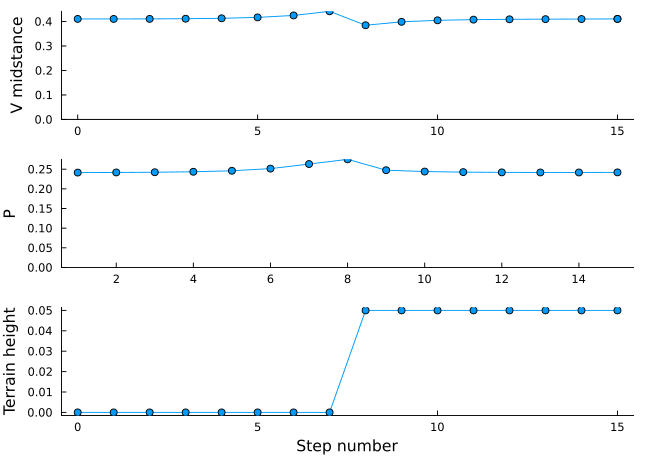

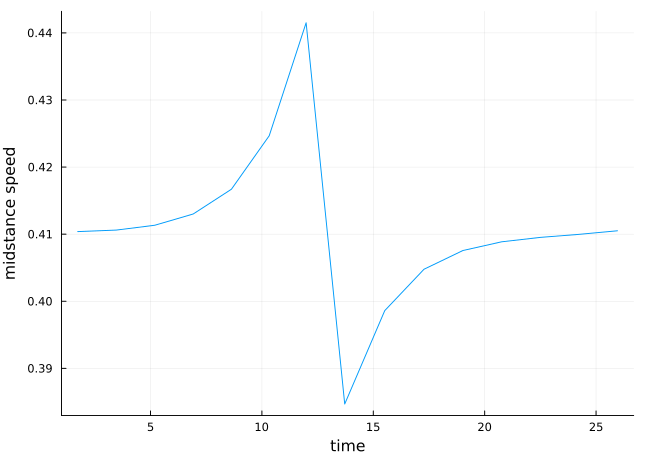

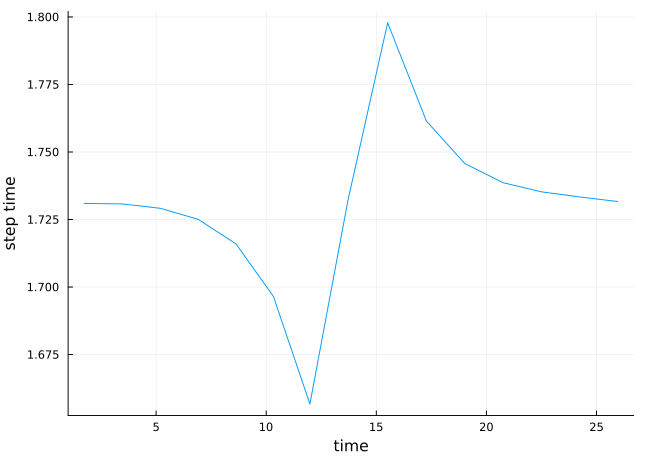

In [1]:
using DynLoco, Plots; 

wstar4s = findgait(WalkRW2l(α=0.4,safety=true), target=:speed=>0.45, varying=:P)
nsteps = 15
δs = zeros(nsteps); δs[Int((nsteps+1)/2)] = 0.05 # one bump
nominalresult = optwalk(wstar4s, nsteps, boundarywork=false, δs=δs)

p = multistepplot(nominalresult, boundarywork=false, legend=false) # plot speed, push-off, terrain heights
display(p)

p = plot(cumsum(nominalresult.steps.tf), nominalresult.steps.vm,xlabel="time",ylabel="midstance speed",legend=false)
display(p)

# step timings, per step
plot(cumsum(nominalresult.steps.tf),nominalresult.steps.tf, xlabel="time",ylabel="step time", legend=false)

The optimization is performed with `optwalk`, which computes the
minimum-work trajectory for `nsteps` of walking. A terrain may be
provided by an array of height/angle changes `δs`.

All quantities are plotted in dimensionless form, with base units of
body mass $M$, leg length $L$, and gravitational acceleration $g$. Thus
speed is normalized by $\sqrt(gL)$ and time by $\sqrt(L/g)$. For a
typical leg length of $L = 1\,\mathrm{m}$, the equivalent dimensional
speed is about 1.25 m/s, and step time about 0.55 s.

## Use varying step lengths to walk over a single upward step

The model above uses fixed step lengths, whereas humans adjust step
length with speed. The model can also be constrained to step at the
preferred step length vs speed relationship of human, resulting in a
different amplitude of speed fluctuations, but a similarly-shaped speed
profile.

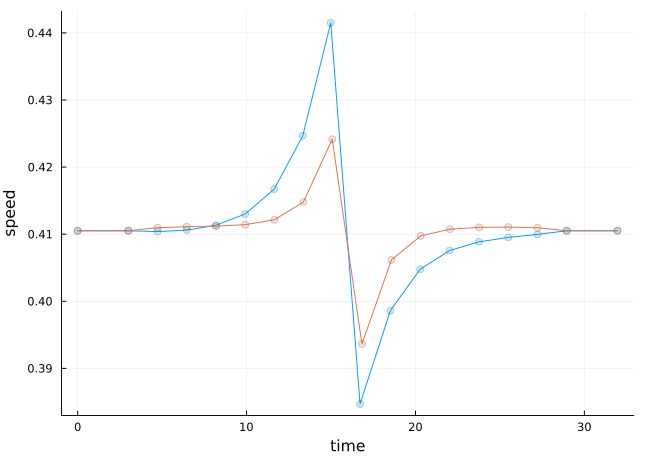

In [2]:
δs = zeros(nsteps); δs[Int((nsteps+1)/2)] = 0.05 # one bump
nominalmsr=optwalk(wstar4s, nsteps, boundarywork=false, δs=δs)
# WalkRW2ls has varying step lengths according to preferred human
wstar4ls = findgait(WalkRW2ls(α=0.4,safety=true), target=:speed=>0.45, varying=:P, cstep=0.35, vmstar=wstar4s.vm)
varyingmsr = optwalk(wstar4ls, nsteps, boundarywork=false,δs=δs)
plotvees(nominalmsr,boundaryvels=nominalmsr.boundaryvels, speedtype=:midstance)
plotvees!(varyingmsr,boundaryvels=nominalmsr.boundaryvels, speedtype=:midstance)

## Walk over a bunch of terrains

The terrain is specified as a series of angle/height changes each step.
The task is to start and end with nominal level walking, and to traverse
the terrain in minimum energy, in the same amount of time as for level
walking.

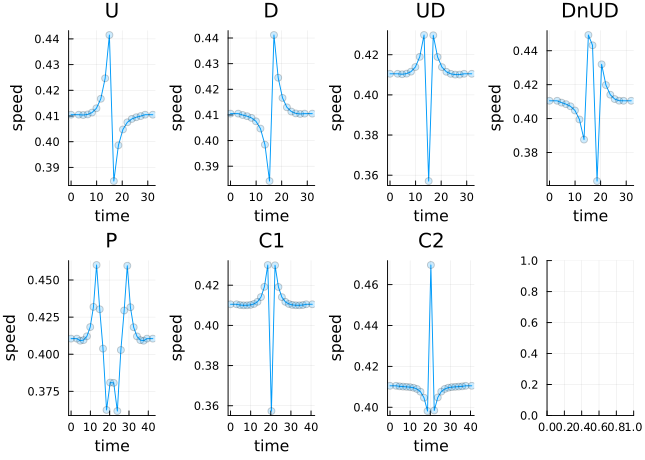

In [3]:
B = 0.05 # bump height, nondimensionalized to leg length L (nominal L = 1 m)
# (bump height affects amplitude of velocity change, but not the shape)

# A bunch of terrains
δs = ( # terrain defined a sequence of height or angle changes from previous step
    "U" =>    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] .* B, # Up
    "D" =>    [0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0] .* B, # Down
    "UD" =>   [0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0] .* B, # Up-Down
    "DnUD" => [0, 0, 0, 0, 0, 0, -1, 0, 1, -1, 0, 0, 0, 0, 0] .* B, # Down & Up-Down
    "P" =>    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0] .* B, # Pyramid
    "C1" =>   [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0] .* B, # Complex 1
    "C2" =>   [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] .* B, # Complex 2
)
p = plot(layout=(2,4), legend=false); plotnum = 1;
for (terrainname, terrainbumps) in δs
    results = optwalk(wstar4s, length(terrainbumps), δs=terrainbumps, boundarywork = false) # optimize push-offs (boundarywork=false means start from nominal walking)
    plotvees!(p[plotnum], results, boundaryvels=results.boundaryvels, speedtype=:midstance, 
        usespline=false,title=terrainname)
    plotnum = plotnum + 1
end
display(p)

## Walk over a simple bump with no compensation

Model walks with constant push-offs for steady walking, and encounters
the up-step without any compensation. As a result of the unexpected
upward step, the model loses speed, and with repeated constant
push-offs, will eventually regain nominal speed. The number of regaining
steps is described by the persistence distance. This model expends the
same energy as level walking, but accumulates a relative time deficit.
The same push-off impulses are applied in both cases, but the
no-compensation case loses speed, resulting in slightly less work. More
detail is available from Darici, Temeltas, and Kuo (2020).

No compensation total work cost = 0.4375814868842951
Nominal walking total work cost = 0.45851198026517315

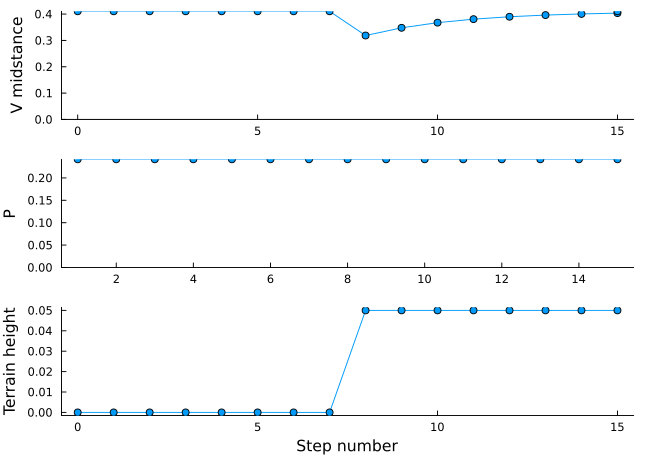

Final time deficit = 1.0701910000831205

In [4]:
upstep = δs[1][2] # first terrain, get the terrain array
nsteps = length(upstep)
nocompresult = multistep(wstar4s, Ps=fill(wstar4s.P,nsteps),δangles=upstep,boundaryvels=(wstar4s.vm,wstar4s.vm))
println("No compensation total work cost = ", nocompresult.totalcost)
println("Nominal walking total work cost = ", nominalresult.totalcost)
p = multistepplot(nocompresult, legend=false, boundarywork=false)
display(p)
plot(cumsum(nominalresult.steps.tf),label="nominal level")
plot!(cumsum(nocompresult.steps.tf), xlabel="step",ylabel="accumulated time", label="no compensation")
println("Final time deficit = ", -sum(nominalresult.steps.tf)+sum(nocompresult.steps.tf))

## Walk over a single bump with a reactive compensation

Model does not anticipate the up-step and loses speed and time upon
first contact with it. Thereafter, the model compensates and catches up
to the level ground model by looking ahead and adjusting the trajectory
of push-offs. It therefore actually anticipates and optimally
compensates for all steps except the first uneven one. This is because
there is no way to regain time without some knowledge and goal for the
terrain ahead. A model that never looks ahead at all would be unable to
walk the same number of steps in the same time as level walking. More
detail is available from Darici, Temeltas, and Kuo (2020).

Reactive contrl total work cost = 0.4629932213996102
Nominal walking total work cost = 0.45851198026517315

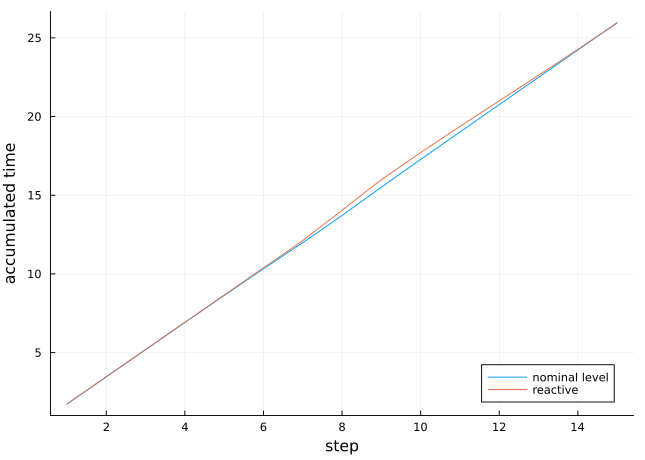

Final time deficit = 0.0

In [5]:
nbump = Int(floor((nsteps+1)/2))
reactresults1 = multistep(wstar4s, Ps=fill(wstar4s.P,nbump),δangles=upstep[1:nbump],boundaryvels=(wstar4s.vm,wstar4s.vm))
reactresults2 = optwalk(wstar4s, nsteps-nbump, totaltime = nominalmsr.totaltime - reactresults1.totaltime,boundaryvels=(reactresults1.steps[end].vm,wstar4s.vm), boundarywork=(false,false))
reactresult = cat(reactresults1, reactresults2)
println("Reactive contrl total work cost = ", reactresult.totalcost)
println("Nominal walking total work cost = ", nominalresult.totalcost)
multistepplot(reactresult,boundarywork=false) # plot concatenation of two simulations
p = plot(cumsum(nominalresult.steps.tf),label="nominal level")
plot!(p, cumsum(reactresult.steps.tf), xlabel="step",ylabel="accumulated time", label="reactive")
display(p)
println("Final time deficit = ", -sum(nominalresult.steps.tf)+sum(reactresult.steps.tf))

# Julia code

This page is viewable as [Jupyter notebook](uneventerrain.ipynb), [plain
Julia](uneventerrain.jl) text, or [HTML](uneventerrain.html).

# Matlab code

There is also extensive Matlab code for an earlier implementation of the
same model. See [Matlab directory](../matlab). There is very limited
documentation of this code.

## References

Darici, Osman, and Arthur D. Kuo. 2022. “Humans Optimally Anticipate and
Compensate for an Uneven Step During Walking.” Edited by Lena H Ting.
*eLife* 11 (January): e65402. <https://doi.org/10.7554/eLife.65402>.

Darici, Osman, Hakan Temeltas, and Arthur D. Kuo. 2020. “Anticipatory
Control of Momentum for Bipedal Walking on Uneven Terrain.” *Scientific
Reports* 10 (1): 540. <https://doi.org/10.1038/s41598-019-57156-6>.